In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import json
import joblib



# dimas


In [160]:
df = pd.read_csv("bbri.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
ts = df["Close"]
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[:train_size], ts[train_size:]
print(f"Ukuran Data Training: {len(train_data)}")
print(f"Ukuran Data Testing: {len(test_data)}")


auto_model_train = pm.auto_arima(train_data, 
                                 start_p=1, start_q=1,
                                 test="adf",
                                 max_p=5, max_q=5,
                                 m=1,
                                 d=None,
                                 seasonal=False,
                                 start_P=0, 
                                 D=0, 
                                 trace=True,
                                 error_action="ignore",  
                                 suppress_warnings=True, 
                                 stepwise=True)

optimal_order = auto_model_train.order
print(f"\nOptimal order (p,d,q) yang ditemukan: {optimal_order}")

print(auto_model_train.summary())

Ukuran Data Training: 2052
Ukuran Data Testing: 514
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21579.347, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21578.488, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21579.056, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21578.899, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21577.967, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.732 seconds

Optimal order (p,d,q) yang ditemukan: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2052
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -10787.983
Date:                Tue, 10 Jun 2025   AIC                          21577.967
Time:                        20:34:26   BIC                          21583.593
Sample:                             0   HQIC     

In [161]:
print(f"--- Melatih Model ARIMA dengan order {optimal_order} ---")
model = ARIMA(train_data, order=optimal_order)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end=len(ts)-1)
predictions.index = test_data.index
rmse = sqrt(mean_squared_error(test_data, predictions))
mape = mean_absolute_percentage_error(test_data, predictions)

print(f"\n--- Metrik Evaluasi Model ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

metrics_dict = {"RMSE": rmse,"MAPE": mape}
nama_file_json = 'eval_arima.json'
with open(nama_file_json, 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print(f"Metrik evaluasi telah disimpan ke file: {nama_file_json}")

# Untuk membuktikan isinya, kita bisa membacanya kembali
with open(nama_file_json, 'r') as f:
    print("\nIsi file JSON yang baru dibuat:")
    print(f.read())

full_df = pd.DataFrame({'Aktual': ts})
full_df['Prediksi'] = predictions
nama_file_lengkap = 'arima.csv'
full_df.to_csv(nama_file_lengkap)



--- Melatih Model ARIMA dengan order (0, 1, 0) ---

--- Metrik Evaluasi Model ---
Root Mean Squared Error (RMSE): 736.92
Mean Absolute Percentage Error (MAPE): 12.96%
Metrik evaluasi telah disimpan ke file: eval_arima.json

Isi file JSON yang baru dibuat:
{
    "RMSE": 736.9203678835524,
    "MAPE": 0.1296084586428348
}


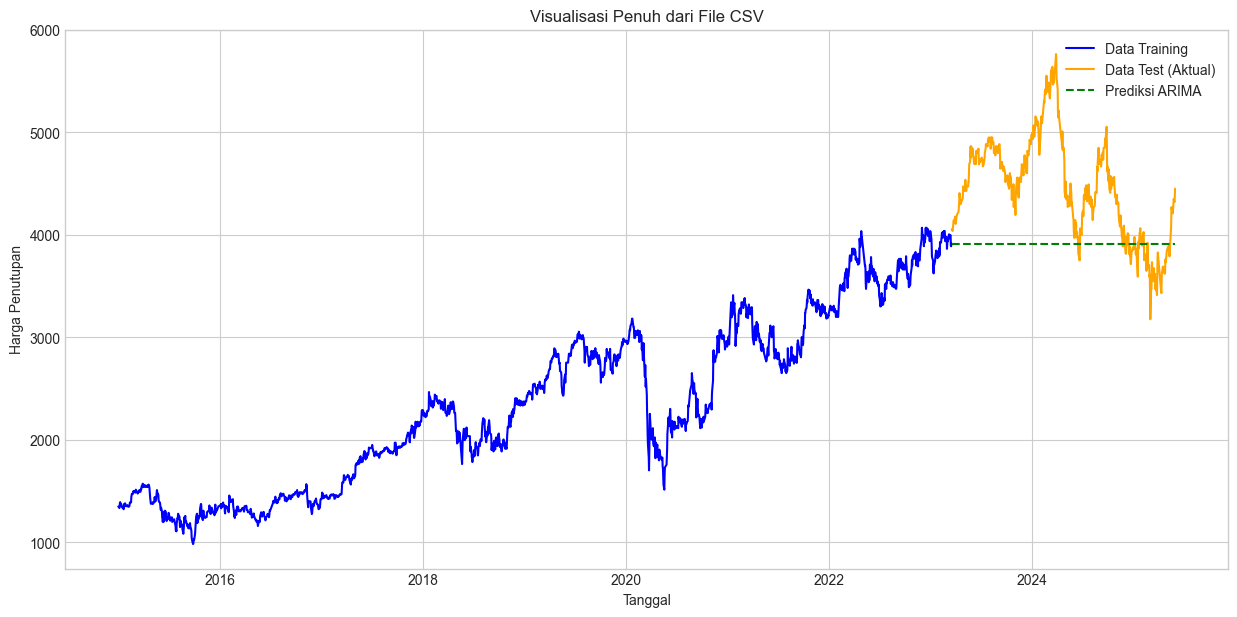

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

nama_file_lengkap = 'arima.csv'

df_from_csv = pd.read_csv(nama_file_lengkap, parse_dates=['Date'], index_col='Date')
train_data_from_csv = df_from_csv['Aktual'][df_from_csv['Prediksi'].isna()]
test_data_from_csv = df_from_csv['Aktual'][df_from_csv['Prediksi'].notna()]
predictions_from_csv = df_from_csv['Prediksi'].dropna()


plt.figure(figsize=(15, 7))
plt.plot(train_data_from_csv, label="Data Training", color='blue')
plt.plot(test_data_from_csv, label="Data Test (Aktual)", color="orange")
plt.plot(predictions_from_csv, label="Prediksi ARIMA", color="green", linestyle='--')
plt.title("Visualisasi Penuh dari File CSV")
plt.xlabel("Tanggal")
plt.ylabel("Harga Penutupan")
plt.legend()
plt.grid(True)
plt.show()

# predick


In [163]:
import joblib

print("--- Mencari order optimal baru dari 100 data (ts) ---")
final_auto_model = pm.auto_arima(ts, 
                                 start_p=1, start_q=1,
                                 test="adf",
                                 max_p=5, max_q=5,
                                 m=1,
                                 d=None,
                                 seasonal=False,
                                 start_P=0, 
                                 D=0, 
                                 trace=True, # Biarkan True untuk melihat proses pencarian
                                 error_action="ignore",  
                                 suppress_warnings=True, 
                                 stepwise=True)

final_optimal_order = final_auto_model.order
print(f"\nOrder optimal BARU yang ditemukan dari 100% data: {final_optimal_order}")

final_model = ARIMA(ts, order=final_optimal_order)
final_model_fit = final_model.fit()

nama_file_model = 'arima.joblib'
joblib.dump(final_model_fit, nama_file_model)



--- Mencari order optimal baru dari 100 data (ts) ---
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27852.922, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27855.451, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27856.020, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27855.764, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27854.683, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27838.603, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27842.401, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27840.768, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27837.430, Time=1.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27838.709, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27842.087, Time=1.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=27837.949, Time=1.71 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27840.720, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercep

['arima.joblib']


Membuat prediksi untuk 30 hari ke depan...
2025-05-29    4445.088947
2025-05-30    4444.595123
2025-05-31    4448.569156
2025-06-01    4444.552534
2025-06-02    4446.183794
2025-06-03    4447.200365
2025-06-04    4444.944634
2025-06-05    4446.710007
2025-06-06    4446.348803
2025-06-07    4445.511534
2025-06-08    4446.682907
2025-06-09    4445.982375
2025-06-10    4445.932647
2025-06-11    4446.476785
2025-06-12    4445.914315
2025-06-13    4446.151393
2025-06-14    4446.284263
2025-06-15    4445.972752
2025-06-16    4446.221798
2025-06-17    4446.166151
2025-06-18    4446.053183
2025-06-19    4446.216060
2025-06-20    4446.116240
2025-06-21    4446.111974
2025-06-22    4446.186415
2025-06-23    4446.107693
2025-06-24    4446.142072
2025-06-25    4446.159353
2025-06-26    4446.116361
2025-06-27    4446.151471
Freq: D, dtype: float64


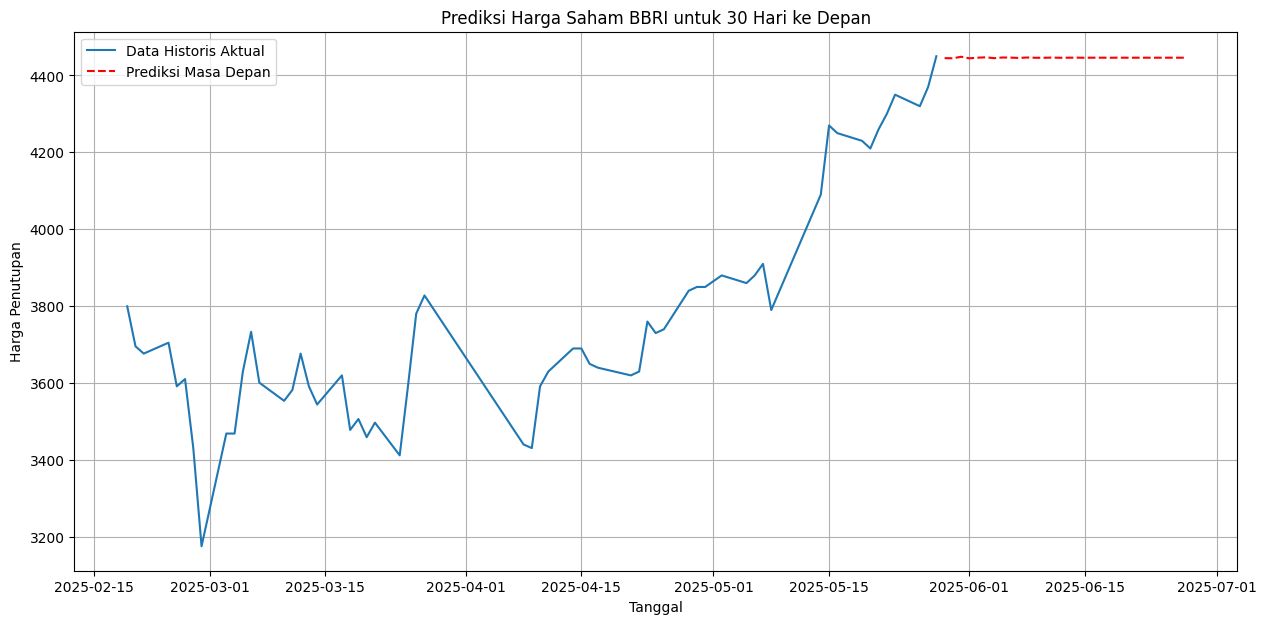

In [9]:
def prediksi_dan_visualisasi(nama_file_model, jumlah_hari, data_historis):
    loaded_model = joblib.load(nama_file_model)
    print(f"\nMembuat prediksi untuk {jumlah_hari} hari ke depan...")

    forecast_values = loaded_model.forecast(steps=jumlah_hari)
    last_date = data_historis.index[-1]
    future_date_index = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                      periods=jumlah_hari, 
                                      freq='D')
    future_forecast = pd.Series(forecast_values.values, index=future_date_index)

    print(future_forecast)

    plt.figure(figsize=(15, 7))
    plt.plot(data_historis.iloc[-60:], label='Data Historis Aktual')
    plt.plot(future_forecast, label='Prediksi Masa Depan', color='red', linestyle='--')
    plt.title(f'Prediksi Harga Saham BBRI untuk {jumlah_hari} Hari ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.show()
    return future_forecast


df_full = pd.read_csv("bbri.csv", parse_dates=['Date'], index_col='Date')
ts_full = df_full['Close']
hasil_prediksi_masa_depan = prediksi_dan_visualisasi(
        nama_file_model='DATA/arima.joblib', 
        jumlah_hari=30, 
        data_historis=ts_full)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def prediksi_dan_visualisasi(nama_file_model, jumlah_hari, data_historis):
    loaded_model = joblib.load(nama_file_model)
    print(f"\nMembuat prediksi untuk {jumlah_hari} hari ke depan...")
    forecast_values = loaded_model.forecast(steps=jumlah_hari)
    last_date = data_historis.index[-1]
    future_date_index = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                      periods=jumlah_hari, 
                                      freq='D')
    future_forecast = pd.Series(forecast_values.values, index=future_date_index)
    # print(future_forecast)
    df_prediksi = future_forecast.to_frame(name='Close')
    df_full['is_prediksi'] = False
    df_prediksi['is_prediksi'] = True
    df_gabungan = pd.concat([df_full, df_prediksi])
    df_gabungan = df_gabungan["Close"]   


    return df_gabungan


# Membaca data historis
df_full = pd.read_csv("bbri.csv", parse_dates=['Date'], index_col='Date')
ts_full = df_full['Close']

# Melakukan prediksi dan mendapatkan hasilnya
hasil_prediksi_masa_depan = prediksi_dan_visualisasi(
    nama_file_model='DATA/arima.joblib', 
    jumlah_hari=3, 
    data_historis=ts_full
)
hasil_prediksi_masa_depan.tail()



Membuat prediksi untuk 3 hari ke depan...


2025-05-27    4370.000000
2025-05-28    4450.000000
2025-05-29    4445.088947
2025-05-30    4444.595123
2025-05-31    4448.569156
Name: Close, dtype: float64